# 2D Gaussian clusters

## Exercise 1.1

To load the dataset, the `numpy.loadtxt` method can be used. This time, the dataset file contains an header in the first line. We will skip it using the method iself.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
X_gauss = np.loadtxt("data/2D_gauss_clusters.txt", delimiter=",", skiprows=1)
X_gauss

array([[845753., 636607.],
       [812954., 643720.],
       [868217., 609046.],
       ...,
       [706472., 171207.],
       [659128., 142611.],
       [665898.,  98088.]])

## Exercise 1.2

Let's use now `matplotlib` to explore our 2D data. Since we are likely going to need a scatter plot multiple times, we can define a simple function to handle it.
> **Hint:** You may use the function `plt.scatter`

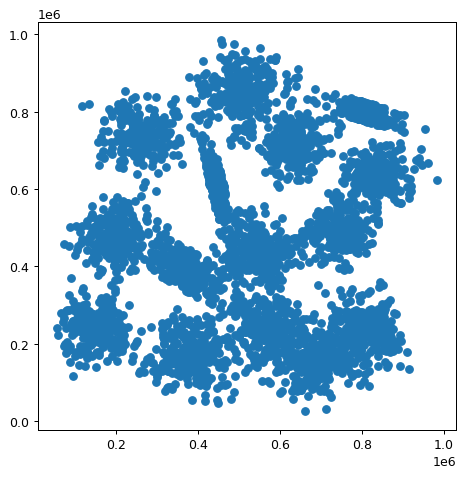

In [4]:
def plot_2d_scatter(X):
    """Display a 2D scatter plot

    :param X: input data points, array
    :return: fig, ax, objects
    """
    fig, ax = plt.subplots(figsize=(6, 6), dpi=90)
    ax.scatter(X[:,0], X[:,1])
    return fig, ax # use them for further modifications

_, _ = plot_2d_scatter(X_gauss) # the two underscores let you discard the returned values

Gaussian, globular clusters are easily visible in the euclidean space. At first sight, you can count up to 15 clusters. Most of them have a regular shape, while some others are more elongated. Given this distribution, we known from theory that the K-means algorithm can achieve positive clustering performance (provided that the right number of cluster is chosen).

## Exercises 1.3

Let's implement now our version of the K-means algorithm. We will use a custom Python class. The basic blocks will be:

- a `fit_predict` method exposed to the users of the class
- a stateful structure: we do want to save the final clusters labels and centroids
- some internal plotting functions
- a `dump_to_file` method to save cluster labels to CSV file (see Exercise 1.4)

In [5]:
class KMeans:
    def __init__(self, n_clusters, max_iter=100):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.centroids = None
        self.labels = None
    
    def __plot_clusters(self, X, labels, c=None):
        fig, ax = plt.subplots(figsize=(6,6), dpi=90)
        ax.scatter(X[:,0], X[:,1], c=labels, cmap='Set3')
        if c is not None: 
            ax.scatter(c[:,0], c[:,1], marker="*", color="red")
        
        return fig, ax
    
    def __init_random_centroids(self, X):
        c_idx = np.random.randint(0, X.shape[0], self.n_clusters)
        c = X[c_idx] # fancy-indexing
        return c

    def fit_predict(self, X, plot_clusters=False, plot_steps=5):
        """Run the K-means clustering on X.
        
        :param X: input data points, array, shape = (N,C).
        :return: labels : array, shape = N.
        """
        # For each point, store the positional index of the closest centroid
        nearest = np.empty(X.shape[0])
        
        c_out = self.__init_random_centroids(X)
        for j in range(self.max_iter):
            nearest_prev = nearest

            # For each point in X, compute the squared distance from each centroid
            # dist will have shape: (n_clusters, X.shape[0])
            dist = np.array([np.sum((X-c_out[i])**2, axis=1) for i in range(self.n_clusters)])

            # Find the nearest centroid for each point using argmin
            # nearest will have shape: (X.shape[0],)
            nearest = dist.argmin(axis=0)

            if plot_clusters and (j % plot_steps == 0):
                fig, ax = self.__plot_clusters(X, nearest, c_out)
                ax.set_title(f"Iteration {j}")
            
            # Early stopping if centroids have not changed 
            if np.array_equal(nearest, nearest_prev):
                print(f"Early stopping at iteration {j}!")
                break

            # For each cluster, compute the average coordinates considering only points currently
            # assigned to it. Then, use them as the new centroid coordinates.
            for i in range(self.n_clusters):
                c_temp = X[nearest == i].mean(axis=0) # indexing with a mask 
                if not np.isnan(c_temp).any(): # handle the case of an empty cluster
                    c_out[i] = c_temp
            
        self.centroids = c_out
        self.labels = nearest
        return self.labels
    
    def dump_to_file(self, filename):
        """Dump the evaluated labels to a CSV file."""
        with open(filename, 'w') as fp:
            fp.write('Id,ClusterId\n')
            for i, label in enumerate(self.labels):
                fp.write(f'{i},{label:d}\n')

In [6]:
np.random.seed(0)
kmeans_model = KMeans(10)
l_gauss = kmeans_model.fit_predict(X_gauss)
l_gauss

Early stopping at iteration 11!


array([1, 1, 1, ..., 5, 5, 5])

In [7]:
kmeans_model.dump_to_file('gauss_labels.csv')

## Exercise 1.4

Let's analyze now the Chameleon dataset just as before.

In [9]:
X_cham = np.loadtxt("data/chameleon_clusters.txt", delimiter=",", skiprows=1)
X_cham

array([[ 68.601997, 102.491997],
       [454.665985, 264.80899 ],
       [101.283997, 169.285995],
       ...,
       [267.605011, 141.725006],
       [238.358002, 252.729996],
       [159.242004, 177.431   ]])

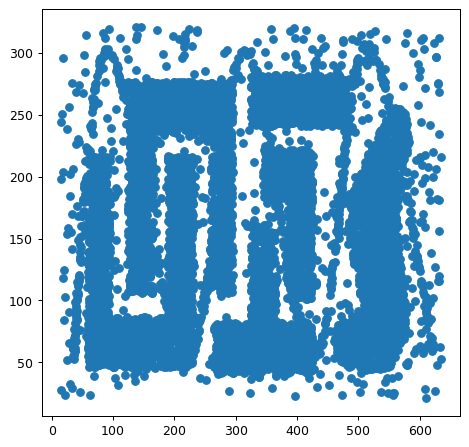

In [10]:
_, _ = plot_2d_scatter(X_cham)

## Exercise 1.5

It is time to enhance our plotting toolkit. We hence define a new function that highlights the final centroids. Specifically, we can use a different marker style and color for them.

In [11]:
def plot_centroids(X, c, title=None):
    fig, ax = plot_2d_scatter(X)
    ax.scatter(c[:,0], c[:,1], marker="*", color="red")
    
    if title:
        ax.set_title(title)
    return fig, ax

Early stopping at iteration 11!
Early stopping at iteration 29!


(<Figure size 540x540 with 1 Axes>,
 <AxesSubplot:title={'center':'Chameleon, K=10'}>)

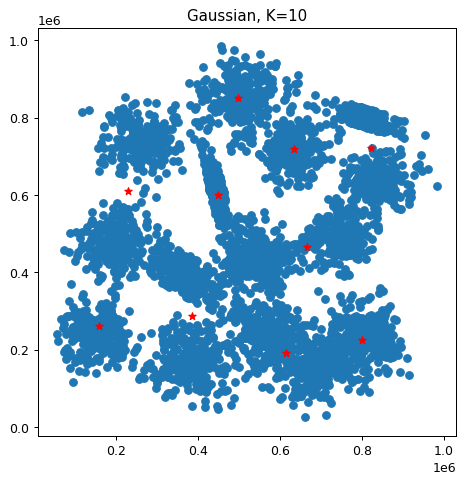

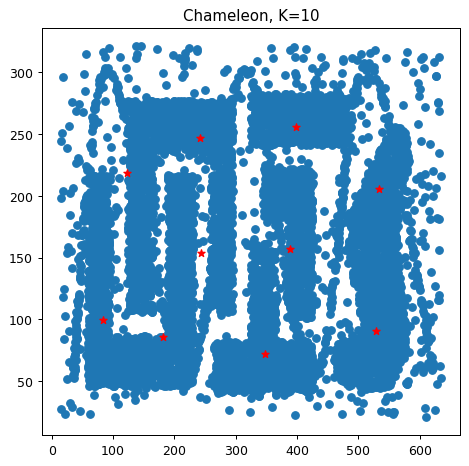

In [12]:
np.random.seed(0)
k_gauss = KMeans(10)
k_cham = KMeans(10)

k_gauss.fit_predict(X_gauss)
k_cham.fit_predict(X_cham)

plot_centroids(X_gauss, k_gauss.centroids, title="Gaussian, K=10")
plot_centroids(X_cham, k_cham.centroids, title="Chameleon, K=10")

# Exercise 1.7
We might be interested to the intermediate position of centroids, other than the final ones. We included this plotting functionality in the `KMeans` class defined above via the `plot_clusters` and `plot_steps` parameters of `fit_predict`. The plot is created in `__plot_clusters`. Take a close look at the `c` and `cmap` parameters. `c` accepts a list used to specify which points must have the same color. Points at indices with equal values in that list will have the same color. `cmap` instead lets you choose a color map among the ones predefined.

Let's test it with Gaussian clusters.

Early stopping at iteration 14!


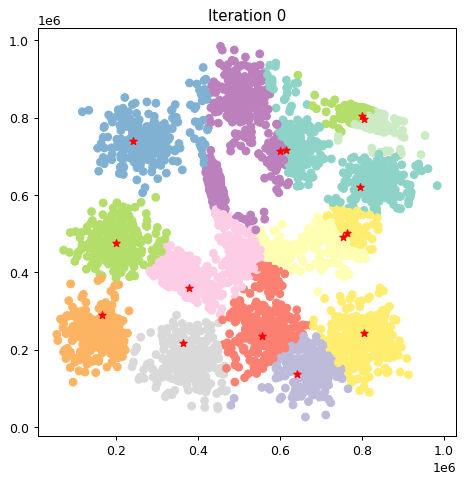

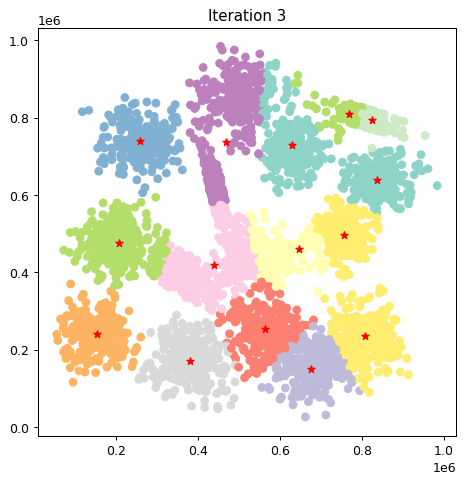

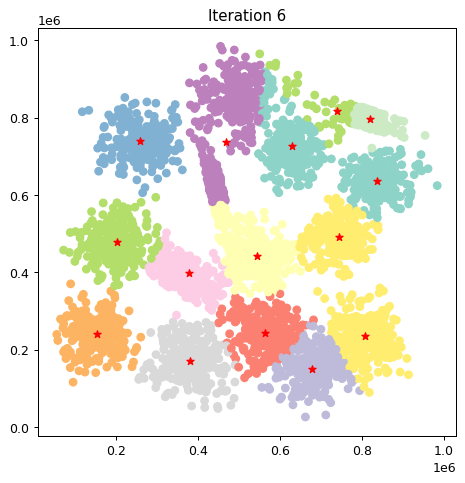

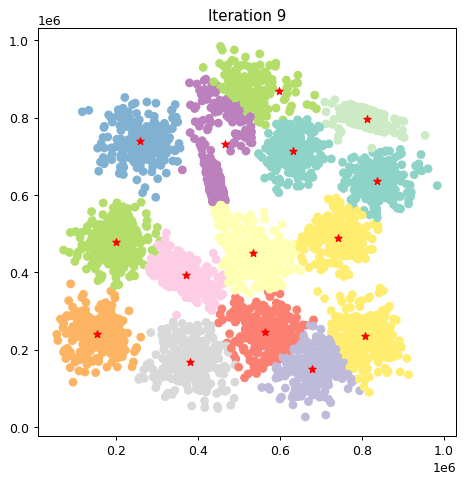

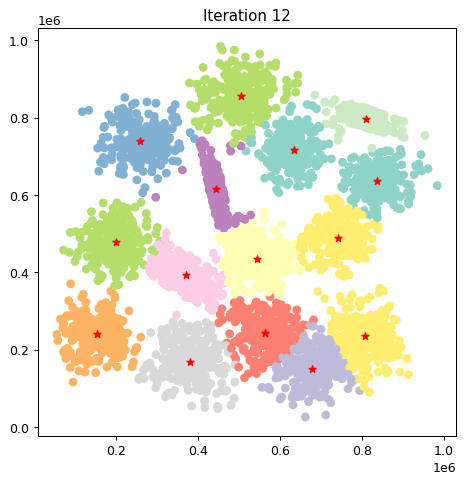

In [13]:
np.random.seed(6)
k_gauss = KMeans(15)
_ = k_gauss.fit_predict(X_gauss, True, 3)

## Exercise 2.1
So far, we have talked about "good" and "bad" clustering results in relation with the capability of K-means to adapt to different data distribution. Our discussions were mainly founded on the final centroids positions. This visual approach could not be feasible with many more points and dimensions.

Whenever numerical data is processed, several distance-based metrics can be used to assess the quality of our clustering. Let's now focus on the Silhouette measure. We can define a couple of functions to compute its value (namely `compute_a` and `compute_b`). Note that we will use the euclidean distance.

In [14]:
def compute_a(x, x_label, X, labels):
    c_idx = np.where(labels == x_label) # we are including the point itself... 
    a = np.mean(np.linalg.norm(x - X[c_idx], axis=1)) # ...because this distance will be 0 when computed from itself.
    return a

def compute_b(x, x_label, X, labels):
    bs = []
    other_labels = np.unique(labels[labels != x_label]) # array with all cluster Ids different from the current one

    for ol in other_labels:
        c_idx = np.where(labels == ol)
        b = np.mean(np.linalg.norm(x - X[c_idx], axis=1))
        bs.append((ol, b))

    neigh, b = min(bs, key=lambda x: x[1])
    return neigh, b

def silhouette_samples(X, labels):
    """Evaluate the silhouette for each point and return them as a list.
    
    :param X: input data points, array, shape = (N,C).
    :param labels: the list of cluster labels, shape = N. :return: silhouette : array, shape = N
    """
    silhouette = np.zeros(X.shape[0])
    for idx in range(X.shape[0]):
        x = X[idx]
        x_label = labels[idx]

        # compute a
        a = compute_a(x, x_label, X, labels)
        # compute b
        _, b = compute_b(x, x_label, X, labels)

        silhouette[idx] = (b - a) / np.max([a, b])
        
    return silhouette

def silhouette_score(X, labels):
    """Evaluate the silhouette for each point and return the mean.
    
    :param X: input data points, array, shape = (N,C).
    :param labels: the list of cluster labels, shape = N. :return: silhouette : float
    """
    return np.mean(silhouette_samples(X, labels))

In [15]:
np.random.seed(6)
k_gauss = KMeans(15)
k_cham = KMeans(6)

l_gauss = k_gauss.fit_predict(X_gauss)
l_cham = k_cham.fit_predict(X_cham)
sil_gauss = silhouette_score(X_gauss, l_gauss)
sil_cham = silhouette_score(X_cham, l_cham)

print('Gaussian clusters, average silhouette:', sil_gauss)
print('Chameleon clusters, average silhouette:', sil_cham)

Early stopping at iteration 14!
Early stopping at iteration 15!
Gaussian clusters, average silhouette: 0.6272254541628367
Chameleon clusters, average silhouette: 0.4134950882250952


## Exercise 2.2
Let's now analyze how the Silhouette values are distributed between our points. To do so, we can plot them in ascending order on the x-axis.

In [16]:
def plot_silhoeutte(silhouette, title=None):
    fig, ax = plt.subplots(figsize=(6,6), dpi=90)
    ax.plot(np.sort(silhouette))
    ax.set_ylabel("Silhouette")
    ax.set_ylim(-1,1)
    ax.set_xlabel("Records")
    if title:
        ax.set_title(title)
    return fig, ax

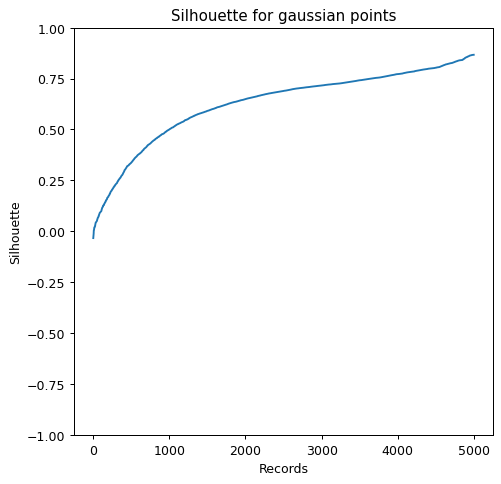

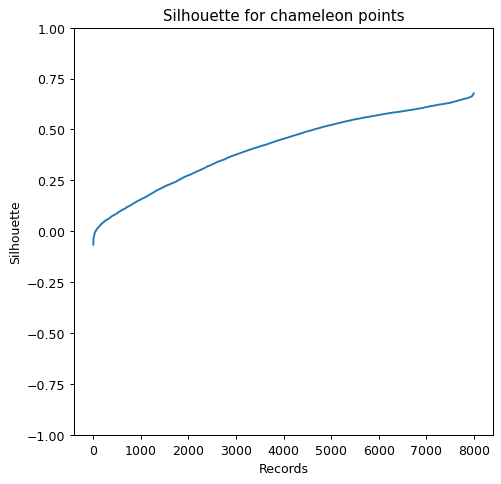

In [17]:
_, _ = plot_silhoeutte(silhouette_samples(X_gauss, l_gauss), "Silhouette for gaussian points")
_, _ = plot_silhoeutte(silhouette_samples(X_cham, l_cham), "Silhouette for chameleon points")


## Exercise 2.3
Until now, we analized results achieved with the right number of cluster as K. Even with the best educational purposes, there is a trick here. We did that because we knew approximately the number of clusters thanks to a prior visual inspection. In many real-world tasks, your data can be spanned on more than two or three dimensions and you cannot visualize them. Hence, it is commonplace to search for the K value that leads to the best possible clustering subdivision. For what concerns the silhouette measure, the higher is the average silhouette the better are the intra-cluster cohesion and the inter-cluster separation.

Let's analyze how our average silhouette varies with different K values for the Gaussian clusters.


Computing K:2
Early stopping at iteration 28!
Computing K:3
Early stopping at iteration 12!
Computing K:4
Early stopping at iteration 10!
Computing K:5
Early stopping at iteration 18!
Computing K:6
Early stopping at iteration 18!
Computing K:7
Early stopping at iteration 25!
Computing K:8
Early stopping at iteration 15!
Computing K:9
Early stopping at iteration 27!
Computing K:10
Early stopping at iteration 16!
Computing K:11
Early stopping at iteration 9!
Computing K:12
Early stopping at iteration 41!
Computing K:13
Early stopping at iteration 27!
Computing K:14
Early stopping at iteration 42!
Computing K:15
Early stopping at iteration 11!
Computing K:16
Early stopping at iteration 9!
Computing K:17
Early stopping at iteration 30!
Computing K:18
Early stopping at iteration 18!
Computing K:19
Early stopping at iteration 18!
Computing K:20
Early stopping at iteration 25!


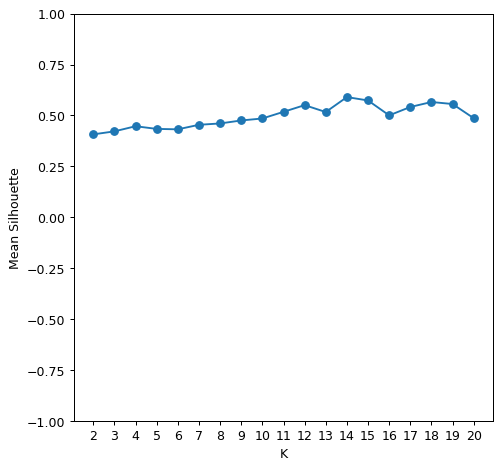

In [18]:
np.random.seed(6)
scores = []
K_values = list(range(2, 21))
for k in K_values:
    print(f"Computing K:{k}")
    kmeans_model = KMeans(k)
    labels = kmeans_model.fit_predict(X_gauss)
    scores.append(silhouette_score(X_gauss, labels))
    
fig, ax = plt.subplots(figsize=(6,6), dpi=90)
ax.plot(scores, marker="o")
ax.set_ylabel("Mean Silhouette")
ax.set_ylim(-1,1)

ax.set_xlabel("K")
ax.set_xticks(list(range(len(K_values))))
_ = ax.set_xticklabels(K_values)

The figure shows a clear trend. The average silhouette value increases almost constantly when K rails from 2 to 14. Then, a plateau is reached with no further improvements after K=15. This is what we expected from our previous analysis.

Note that here the highest value is achieved with K=14. This is possible, although the right number of cluster is 15, since we are working with euclidean distances and clusters are not completely separated from each other.